In [6]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np
from utils.models import mGradNet_C, mGradNet_M, WSoftmax, WTanh
from utils.pdfs import MultivariateNormal
import matplotlib.pyplot as plt 

# set random seeds for reproducibility
np.random.seed(1234)
torch.manual_seed(1234)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1234)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

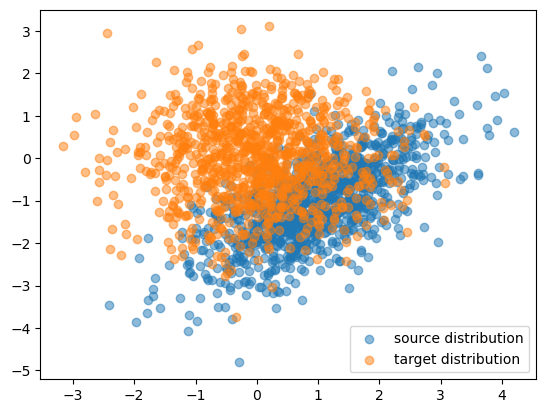

In [7]:
source_mu = torch.tensor([1.0, -1.0])
source_cov = torch.tensor([[1.0, 0.7], [0.7, 1.0]])
source = MultivariateNormal(source_mu, source_cov)
target = MultivariateNormal(torch.tensor([0.0, 0.0]), torch.eye(2))

source_samples = source.sample(1000)
target_samples = target.sample(1000)
plt.scatter(source_samples[:,0], source_samples[:,1], label='source distribution', alpha=0.5)
plt.scatter(target_samples[:,0], target_samples[:,1], label='target distribution', alpha=0.5)
plt.legend()

In [8]:
from torch.optim import Adam, SGD
from torch.func import vmap, jacrev
from torch.nn.utils import clip_grad_norm_
from tqdm import trange

# Define the OT map model
otmap_name = 'mGradNet_M'  # Choose between 'mGradNet_C', 'mGradNet_M', 'baseline'

if otmap_name == 'mGradNet_C':
    otmap = mGradNet_C(in_dim=2, embed_dim=32, num_layers=4, activation=lambda: nn.Tanh())
    
elif otmap_name == 'mGradNet_M':
    otmap = mGradNet_M(num_modules=4, in_dim=2, embed_dim=32, activation=lambda: WSoftmax(32))
    
elif otmap_name == 'baseline':

    otmap = nn.Sequential(
        nn.Linear(2, 128),
        nn.Tanh(),
        nn.Linear(128, 128),
        nn.Tanh(),
        nn.Linear(128, 128),
        nn.Tanh(),
        nn.Linear(128, 2)
    )

else:
    raise ValueError("Unknown OT map type specified.")


# Train the OT map
otmap = otmap.to(device)
otmap.train()
opt = Adam(otmap.parameters(), lr=1e-2)
jacobian_fn = jacrev(otmap)
batched_jacobian_fn = vmap(jacobian_fn)

pbar = trange(1000, dynamic_ncols=True) # train for 1000 iterations
for i in pbar:
    opt.zero_grad()
    samples = source.sample(1000).to(device)  # sample points from the source distribution
    out = otmap(samples)
   
    J = batched_jacobian_fn(samples)
    J = J.squeeze(1)
    
    _, logabsdet = torch.linalg.slogdet(J)

    log_p = source.log_pdf(samples)       # source log-density
    log_q = target.log_pdf(out)           # target log-density

    loss = F.l1_loss(logabsdet, log_p - log_q)
    loss.backward()
    clip_grad_norm_(otmap.parameters(), max_norm=2.0) # clip gradient norms for stability
    opt.step()
    
    pbar.set_description(f"Loss: {loss.item():.4f}")

Loss: 0.0115: 100%|██████████| 1000/1000 [00:13<00:00, 73.76it/s]


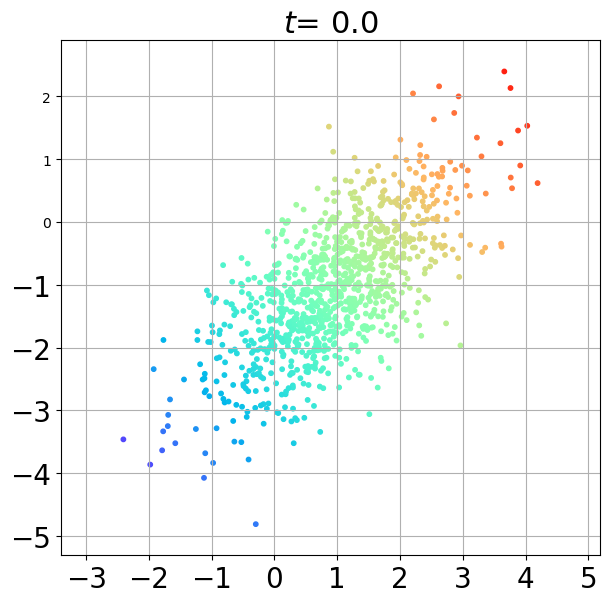

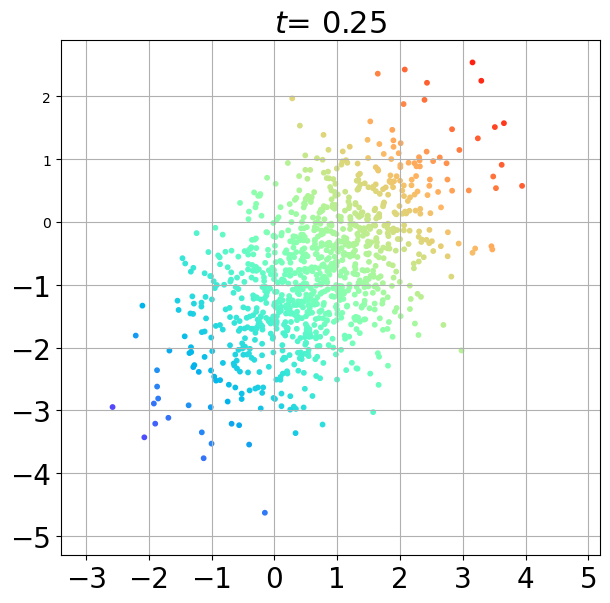

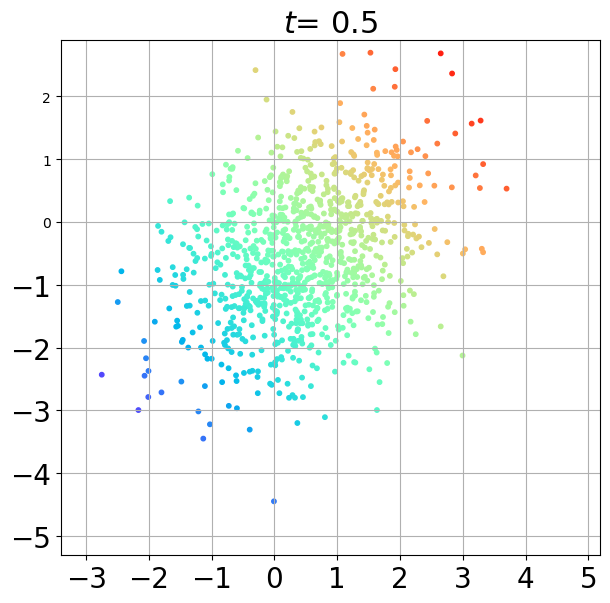

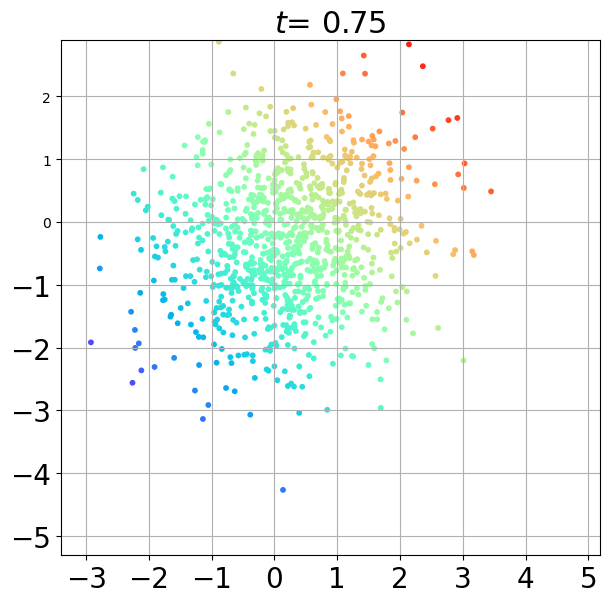

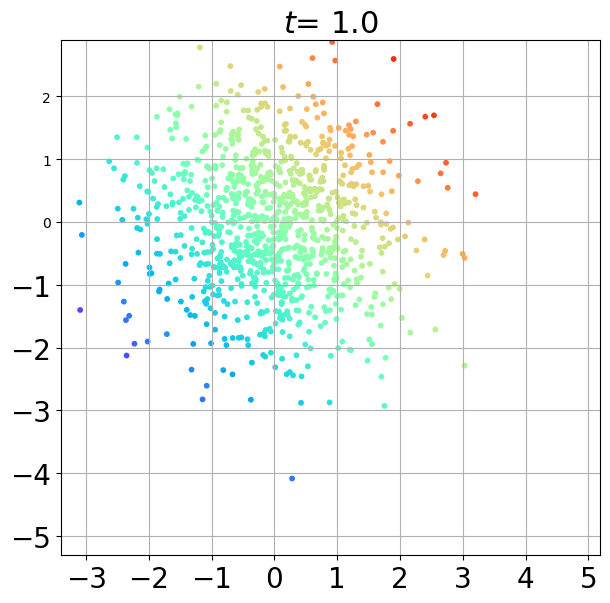

In [9]:
# Plot the learned OT map
from matplotlib.cm import rainbow
import os

otmap.eval()
t_vals = np.linspace(0, 1, 5)

# Normalize 2D positions to [0, 1] for coloring
source_samples = source_samples.to(device)
x_min, x_max = source_samples[:, 0].min(), source_samples[:, 0].max()
y_min, y_max = source_samples[:, 1].min(), source_samples[:, 1].max()

X_norm = torch.zeros_like(samples)
X_norm[:, 0] = (source_samples[:, 0] - x_min) / (x_max - x_min + 1e-8)
X_norm[:, 1] = (source_samples[:, 1] - y_min) / (y_max - y_min + 1e-8)

# Combine x and y into a single scalar for colormap mapping
color_weights = 0.5 * X_norm[:, 0] + 0.5 * X_norm[:, 1]  # weighted average
colors = rainbow(color_weights.cpu())

path = 'figures/gaussians/' + str(otmap_name)
os.makedirs(path, exist_ok=True)
for t in t_vals:
    interpolated = (1 - t) * source_samples.cpu() + t * otmap(source_samples).cpu().detach()
    plt.figure(figsize=(6, 6))
    plt.scatter(interpolated[:, 0], interpolated[:, 1], s=10, color=colors, label=f"t={t:.2f}")
    plt.title('$t$= ' + str(t), fontsize=22)
    plt.axis("equal")
    plt.grid(True)
    plt.tight_layout()
    plt.xlim(x_min.cpu() - 1, x_max.cpu() + 1)
    plt.ylim(y_min.cpu() - 1, y_max.cpu() + 1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig(path + '/t'+ str(t)+'.pdf', bbox_inches='tight')
    plt.show()

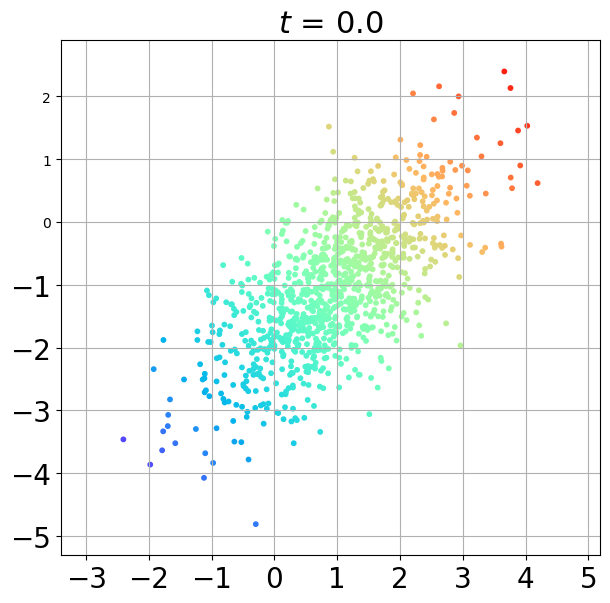

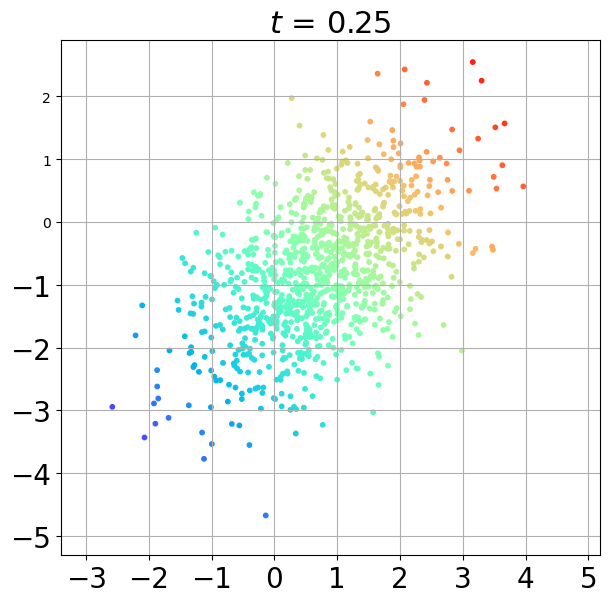

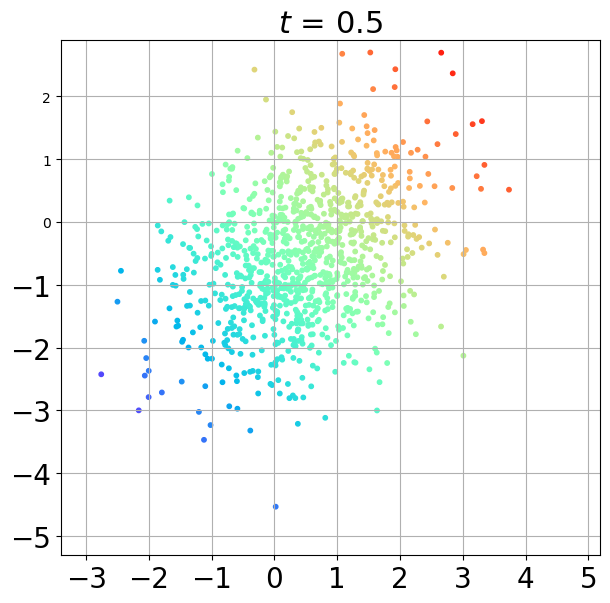

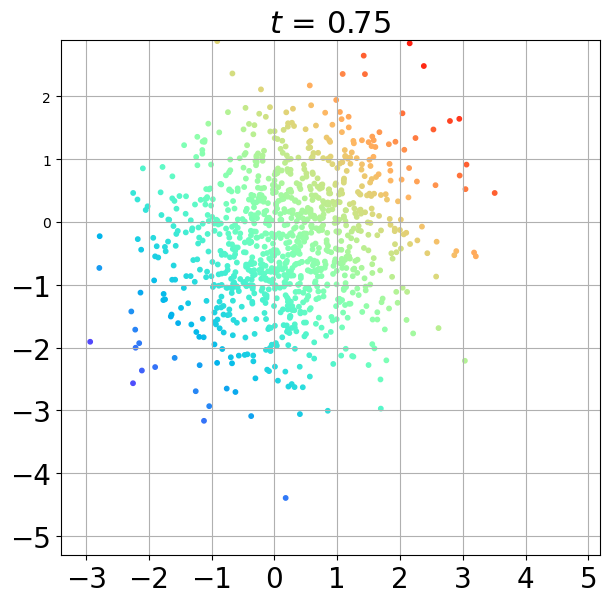

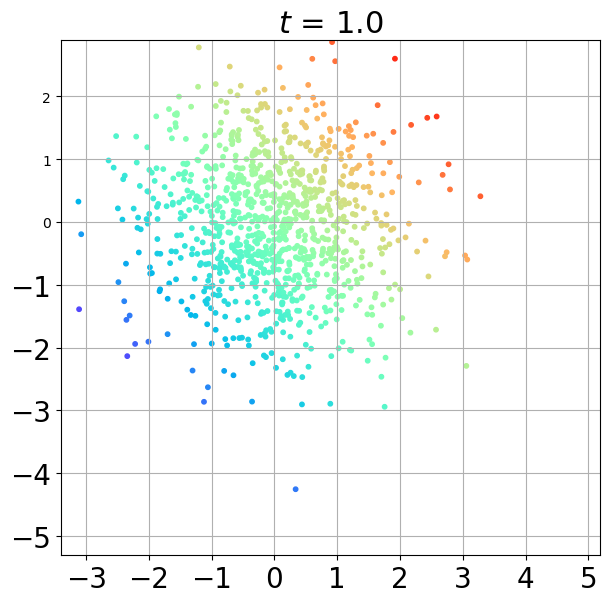

In [10]:
# Plot the ground truth OT map

def inv_sqrt(A):
    eigvals, eigvecs = torch.linalg.eigh(A)
    return eigvecs @ torch.diag(eigvals.pow(-0.5)) @ eigvecs.T

A = inv_sqrt(source_cov)
def optimal_ot_map(x):
    z = x - source_mu
    return z @ A

path = 'figures/gaussians/whitening'
os.makedirs(path, exist_ok=True)
source_samples = source_samples.cpu()
for t in t_vals:
    interpolated = (1 - t) * source_samples + t * optimal_ot_map(source_samples).cpu().detach()
    plt.figure(figsize=(6, 6))
    plt.scatter(interpolated[:, 0], interpolated[:, 1], s=10, color=colors, label=f"t={t:.2f}")
    plt.title('$t$ = ' + str(t), fontsize=22)
    plt.axis("equal")
    plt.grid(True)
    plt.tight_layout()
    plt.xlim(x_min.cpu() - 1, x_max.cpu() + 1)
    plt.ylim(y_min.cpu() - 1, y_max.cpu() + 1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig(path + '/t' + str(t)+'.pdf', bbox_inches='tight')
    plt.show()